In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os
import tensorflow as tf

In [ ]:
! mkdir -p /root/.kaggle/
! mv kaggle.json /root/.kaggle/

In [ ]:
import kaggle

In [ ]:
! kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:43<00:00, 19.8MB/s]
100% 812M/812M [00:43<00:00, 19.6MB/s]


In [ ]:
! unzip -q dogs-vs-cats.zip

In [ ]:
! unzip -q train.zip

In [ ]:
data = pd.DataFrame(columns=["filename", "label"])
data["filename"] = os.listdir("train/")

In [ ]:
data["label"]= data["filename"].str.split(".", expand=True)[0]

In [ ]:
data.sample(5)

,filename,label
23389,cat.2840.jpg,cat
18603,dog.3956.jpg,dog
22095,cat.3534.jpg,cat
6111,cat.11255.jpg,cat
4002,dog.4362.jpg,dog


In [ ]:
# VGG Pre Processing
! wget https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg

--2023-06-25 16:20:14--  https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229955 (225K) [image/jpeg]
Saving to: ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’

dog-puppy-on-garden 100%[===================>] 224.57K  --.-KB/s    in 0.003s  

2023-06-25 16:20:14 (80.3 MB/s) - ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’ saved [229955/229955]



In [ ]:
image = tf.keras.preprocessing.image.load_img("dog-puppy-on-garden-royalty-free-image-1586966191.jpg")
# image

In [ ]:
image_arr = tf.keras.preprocessing.image.img_to_array(image)
type(image_arr), image_arr.shape

(numpy.ndarray, (1499, 1999, 3))

In [ ]:
image_pre = tf.keras.applications.vgg16.preprocess_input(image_arr)
image_pre.shape

(1499, 1999, 3)

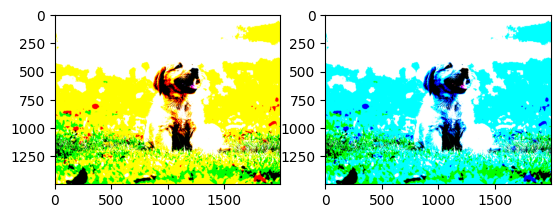

In [ ]:
plt.subplot(121)
plt.imshow(image_arr)
plt.subplot(122)
plt.imshow(image_pre)

In [ ]:
# We cant rescale this time, VGG is built on someother preprocessing
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                                      validation_split=0.1)

In [ ]:
batch_size = 64

In [ ]:
train_idg = idg.flow_from_dataframe(data, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=(300, 300), subset="training")

Found 22500 validated image filenames belonging to 2 classes.


In [ ]:
val_idg = idg.flow_from_dataframe(data, "train/", x_col="filename", y_col="label",
                                  batch_size = batch_size,
                                  target_size = (300, 300), subset="validation")

Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
# del vgg16_model

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(300, 300, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
# How do we make sure, that BP doesnt update the filter of our Conv Layers
# by deafult all layers are set to be trainable, and we need to stop for VGG's Conv layer
for layer in vgg16_model.layers:
  print(layer.name, layer.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
for layer in vgg16_model.layers:
  layer.trainable = False

In [ ]:
for layer in vgg16_model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
# Functional Model!

flat = tf.keras.layers.Flatten() (vgg16_model.output)
dense1 = tf.keras.layers.Dense(128, activation="relu") (flat)
# dense2 = tf.keras.layers.Dense(32, activation="relu") (dense1)
output = tf.keras.layers.Dense(2, activation="softmax") (dense1)

In [ ]:
final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output])

In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

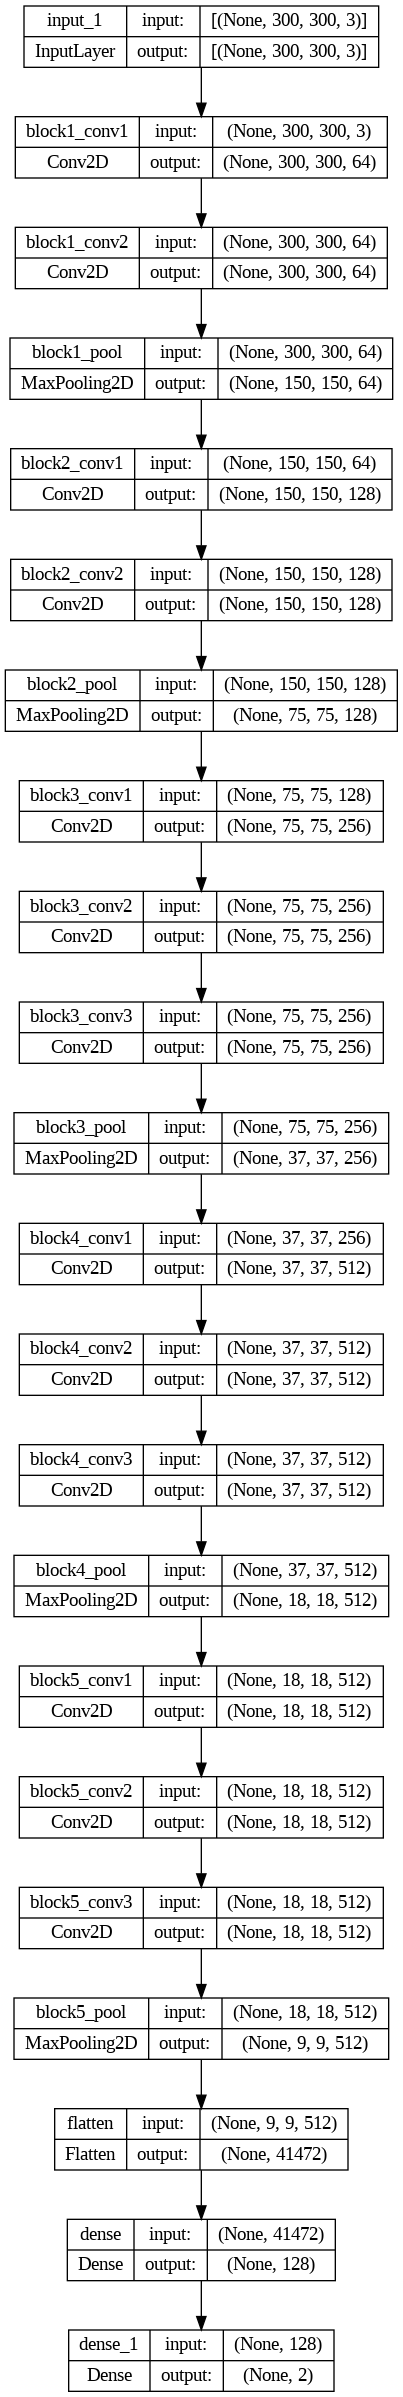

In [ ]:
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_names=True)

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [ ]:
final_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs=20)

Epoch 1/20
352/352 [==============================] - 236s 610ms/step - loss: 1.6874 - acc: 0.9698 - val_loss: 0.0623 - val_acc: 0.9796
Epoch 2/20
352/352 [==============================] - 209s 593ms/step - loss: 0.0245 - acc: 0.9924 - val_loss: 0.0616 - val_acc: 0.9828
Epoch 3/20
352/352 [==============================] - 210s 595ms/step - loss: 0.0073 - acc: 0.9970 - val_loss: 0.0765 - val_acc: 0.9816
Epoch 4/20
352/352 [==============================] - 210s 596ms/step - loss: 0.0034 - acc: 0.9982 - val_loss: 0.0804 - val_acc: 0.9828
Epoch 5/20
352/352 [==============================] - 210s 595ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.0942 - val_acc: 0.9832
Epoch 6/20
352/352 [==============================] - 210s 594ms/step - loss: 0.0014 - acc: 0.9991 - val_loss: 0.0974 - val_acc: 0.9828
Epoch 7/20
248/352 [====================>.........] - ETA: 55s - loss: 0.0012 - acc: 0.9992